In [63]:
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from common.env.atari_wrappers import AttentionGuider
from common.model import ConceptNatureModel
from common.policy import ConceptPolicy
from gymnasium.wrappers import AutoResetWrapper, RecordEpisodeStatistics
from gymnasium.wrappers.normalize import RunningMeanStd

#### Wrapper

In [64]:
class NormalizeObservation(gym.Wrapper, gym.utils.RecordConstructorArgs):
    """This wrapper will normalize observations s.t. each coordinate is centered with unit variance.

    Note:
        The normalization depends on past trajectories and observations will not be normalized correctly if the wrapper was
        newly instantiated or the policy was changed recently.
    """

    def __init__(self, env: gym.Env, epsilon: float = 1e-8):
        """This wrapper will normalize observations s.t. each coordinate is centered with unit variance.

        Args:
            env (Env): The environment to apply the wrapper
            epsilon: A stability parameter that is used when scaling the observations.
        """
        gym.utils.RecordConstructorArgs.__init__(self, epsilon=epsilon)
        gym.Wrapper.__init__(self, env)

        try:
            self.num_envs = self.get_wrapper_attr("num_envs")
            self.is_vector_env = self.get_wrapper_attr("is_vector_env")
        except AttributeError:
            self.num_envs = 1
            self.is_vector_env = False

        if self.is_vector_env:
            self.obs_rms = RunningMeanStd(shape=self.single_observation_space.shape)
        else:
            self.obs_rms = RunningMeanStd(shape=self.observation_space.shape)
        self.epsilon = epsilon

    def step(self, action):
        """Steps through the environment and normalizes the observation."""
        obs, rews, terminateds, truncateds, infos = self.env.step(action)
        infos['origin_obs'] = obs
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        return obs, rews, terminateds, truncateds, infos

    def reset(self, **kwargs):
        """Resets the environment and normalizes the observation."""
        obs, info = self.env.reset(**kwargs)
        info['origin_obs'] = obs
        if self.is_vector_env:
            return self.normalize(obs), info
        else:
            return self.normalize(np.array([obs]))[0], info

    def normalize(self, obs):
        """Normalises the observation using the running mean and variance of the observations."""
        self.obs_rms.update(obs)
        return (obs - self.obs_rms.mean) / np.sqrt(self.obs_rms.var + self.epsilon)

#### Utils

In [65]:
def alpha_blending(original_image, concept_attn, patch_size, alpha, threshold, color_list):
    num_concepts = concept_attn.shape[-1]
    attention_image = np.copy(original_image) / 255.
    num_patches_row = original_image.shape[0] // patch_size
    num_patches_col = original_image.shape[1] // patch_size
    attention_image *= (1 - alpha)
    for c in range(num_concepts):
        attention_map = concept_attn[:, c].reshape((num_patches_row, num_patches_col))
        attention_map = (attention_map > threshold).astype(float)
        attention_map = np.repeat(np.repeat(attention_map, patch_size, axis=0), patch_size, axis=1)
        attention_image += alpha * attention_map[:, :, np.newaxis] * color_list[c]
    attention_image *= 255
    attention_image = attention_image.astype(np.uint8)
    
    return attention_image

def hex_to_rgb(hex):
  return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

def make_envs(n_env, env_id, concept_dict=None, search_area=None, patch_size=None):
        def make_env():
            env = gym.make(env_id)
            env = AttentionGuider(env, concept_dict, search_area, patch_size)
            env = AutoResetWrapper(env)
            return env
        return gym.vector.SyncVectorEnv([make_env for _ in range(n_env)])

#### Environment

In [145]:
env_name = 'ALE/Pong-v5'
patch_size = 10

concept_dict = {
    "player": np.array([92, 186, 92]),
    "enemy": np.array([213, 130, 74]),
    "ball": np.array([236, 236, 236]),
}
search_area = [[34, 194],[]]
env = make_envs(1, env_name, concept_dict, search_area, patch_size)
env = NormalizeObservation(env)
env = RecordEpisodeStatistics(env)
hex_color_list = ['#A52A2A', '#008B8B', '#8FBC8F']
color_list = [np.array(hex_to_rgb(hex_color_list[i][1:]))/255. for i in range(len(hex_color_list))]
concepts = ["Player", "Enemy", "Ball"]

/root/miniconda3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/root/miniconda3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(
/root/miniconda3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` fo

#### Agent

In [133]:
class EvaluateAgent:
    def __init__(self,
                 policy,
                 device) -> None:
        self.policy = policy
        self.device = device
    
    def predict(self, obs, hidden_state, done):
        with torch.no_grad():
            obs = torch.FloatTensor(obs).to(device=self.device)
            hidden_state = torch.FloatTensor(hidden_state).to(device=self.device)
            mask = torch.FloatTensor(1 - done).to(device=self.device)
            dist, value, mask_attn, concept_attn = self.policy(obs, hidden_state, mask)
            act = dist.sample()
            log_prob_act = dist.log_prob(act)
        return act.cpu().numpy(), log_prob_act.cpu().numpy(), value.cpu().numpy(), hidden_state.cpu().numpy(), concept_attn.cpu().numpy()

In [155]:
param_dict = {'num_heads': 2, 'n_concepts': len(concept_dict.keys())}
embedder = ConceptNatureModel(in_channels=3, patch_size=patch_size, output_dim=64)
policy = ConceptPolicy(embedder=embedder, recurrent=False, action_size=env.action_space[0].n, **param_dict)
agent = EvaluateAgent(policy=policy, device='cuda')
agent.policy.load_state_dict(torch.load('trained_models\Pong\AG_Policy\model.pth',
                             map_location='cuda')['state_dict'])
agent.policy.cuda()
print('MODEL LOADED')

MODEL LOADED


#### Evaluation

In [165]:
obs, info = env.reset()
time_step = 0
attention_image_list = []
concept_attn_list = []
hidden_state = np.zeros(256)
done = False
last_obs = info['origin_obs'][0]
while time_step < 200:
    act, log_prob_act, value, next_hidden_state, expl_pred = agent.predict(obs, hidden_state, done)
    next_obs, reward, done, truncated, info = env.step(act)
    attention_image = alpha_blending(
        original_image = last_obs,
        concept_attn = expl_pred[0],
        patch_size=patch_size,
        alpha = 0.5,
        threshold = 0.5,
        color_list = color_list
    )
    last_obs = info['origin_obs'][0]
    attention_image_list.append(attention_image)
    concept_attn_list.append(expl_pred[0])
    obs = next_obs
    time_step += 1

#### Explanations

- `#A52A2A` (Red) : Player
- `#008B8B` (Blue) : Enemy
- `#8FBC8F` (Green) : Ball

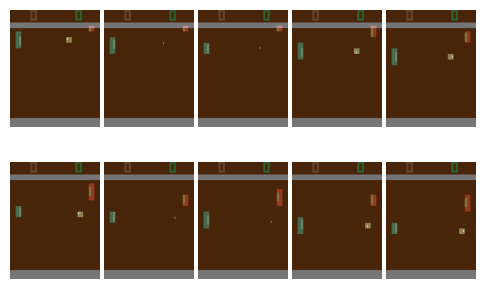

In [196]:
fig = plt.figure(dpi=100)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(attention_image_list[50+i])
    plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)

#### Marginal Distribution

- `#A52A2A` (Red) : Player
- `#008B8B` (Blue) : Enemy
- `#8FBC8F` (Green) : Ball

The distribution of attention weights on each head for Pong frame. The two stacked bar plots show the sum of the weights along the x and y axis (the range of each plot is [0, 1].)

You can feel free to modify `FRAME` below to see results in other frames.

(-1.3, 16.3, 0.0, 2.9642510414123535)

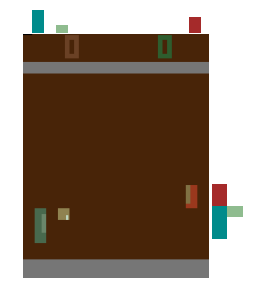

In [190]:
FRAME = 25
x_list = []
y_list = []
fig = plt.figure(dpi=100)
gs = GridSpec(260,210)
time_step += 1
ax_joint = fig.add_subplot(gs[21:231,0:160])
ax_marg_x = fig.add_subplot(gs[0:20,32:128])
ax_marg_y = fig.add_subplot(gs[21:231,123:138])
ax_joint.imshow(attention_image_list[FRAME])
bottom_x = np.zeros(16)
bottom_y = np.zeros(21)
for idx in range(len(concept_dict)):
    concept_map = concept_attn_list[FRAME][:, idx].reshape((attention_image.shape[0] // patch_size, attention_image.shape[1] // patch_size))
    concept_map = np.where(concept_map>0.5, concept_map, 0.0)
    x_list.append(concept_map.sum(axis=0))
    y_list.append(concept_map.sum(axis=1))
for idx in range(len(concept_dict)):
    x = x_list[idx]
    y = y_list[idx]
    ax_marg_x.bar(x = np.arange(0, len(x)), height=x, alpha=1, width=1, color = hex_color_list[idx], bottom=bottom_x)
    ax_marg_y.barh(y = np.arange(len(y), 0, -1), height=y, alpha=1, width=1, color = hex_color_list[idx], left=bottom_y)
    bottom_x = x_list[idx] + bottom_x
    bottom_y = y_list[idx] + bottom_y

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Turn off axis
ax_joint.axis('off')
ax_marg_y.axis('off')
ax_marg_x.axis('off')